In [31]:
import duckdb
import torch
import torch.nn.functional as F
import torch_frame as tf
from torch_frame.data import Dataset
from torch_frame.utils import infer_df_stype
from torch_frame.data.loader import DataLoader
from torch_frame.nn.encoder import EmbeddingEncoder, LinearEncoder
from torch_frame.nn.models import FTTransformer   # any backbone works

# -----------------------------------------------------------
# 1.  Read & sample exactly the same way you did
# -----------------------------------------------------------
file_path = "../data/parcel_tracking_output_data.parquet"
df = duckdb.sql(f"""
    SELECT * FROM '{file_path}'
    USING SAMPLE reservoir(100 ROWS)
    REPEATABLE (100)
""").df()

# Targets ----------------------------------------------------
ETA_COL   = "total_hours_from_receiving_to_last_success_delivery"
POD_COL   = "is_successful_delivery"

# Cast targets to numeric
# df[ETA_COL] = df[ETA_COL].astype(float)
# df[POD_COL] = df[POD_COL].astype(int)
df.drop(columns=["customer_id", "parcel_id"], inplace=True)

In [ ]:
eta_df = df.drop(columns=[POD_COL])
pod_df = df.drop(columns=[ETA_COL])

# 2. Build two Dataset objects (one per task)
eta_col_to_stype = infer_df_stype(eta_df)
eta_col_to_stype[ETA_COL] = tf.numerical

pod_col_to_stype = infer_df_stype(pod_df)
pod_col_to_stype[POD_COL] = tf.categorical

eta_ds = Dataset(eta_df, col_to_stype=eta_col_to_stype, target_col=ETA_COL)
pod_ds = Dataset(pod_df, col_to_stype=pod_col_to_stype, target_col=POD_COL)

24
24


In [33]:
# Materialise once so we can reuse stats & mappings
eta_ds.materialize()              # gives .tensor_frame, .col_stats
pod_ds.materialize()

Dataset()

In [34]:
# Split ------------------------------------------------------
train_eta = eta_ds[:0.8]    # same slice trick as in quick‑tour :contentReference[oaicite:3]{index=3}
val_eta   = eta_ds[0.8:]
train_pod = pod_ds[:0.8]
val_pod   = pod_ds[0.8:]

# 3.  Mini‑batch loaders
BATCH = 5
train_eta_loader = DataLoader(train_eta, batch_size=BATCH, shuffle=True)
val_eta_loader   = DataLoader(val_eta,   batch_size=BATCH)

train_pod_loader = DataLoader(train_pod, batch_size=BATCH, shuffle=True)
val_pod_loader   = DataLoader(val_pod,   batch_size=BATCH)

In [35]:
for batch in train_pod_loader:
    print(batch)
    break

TensorFrame(
  num_cols=23,
  num_rows=5,
  categorical (5): ['Rush_hour', 'is_successful_delivery_at_first_time', 'last_delivery_datetime_is_non_working_day', 'parcel_category_id', 'received_datetime_is_non_working_day'],
  numerical (18): ['delivery_post_office_address_latitude', 'delivery_post_office_address_longtitude', 'delivery_post_office_id', 'distance_delivery_post_office_recipient_address', 'distance_received_post_office_delivery_post_office', 'distance_received_post_office_recipient_address', 'last_delivery_datetime_day', 'last_delivery_datetime_hour', 'last_delivery_datetime_month', 'received_datetime_day', 'received_datetime_hour', 'received_datetime_month', 'received_post_office_address_latitude', 'received_post_office_address_longtitude', 'received_post_office_id', 'recipient_address_latitude', 'recipient_address_longtitude', 'total_hours_from_receiving_to_last_failed_delivery'],
  has_target=True,
  device='cpu',
)


In [36]:
# 4. Common stype‑wise encoders
stype_enc = {
    tf.stype.categorical: EmbeddingEncoder(),
    tf.stype.numerical:   LinearEncoder(),
}

In [49]:
# 5‑A. ETA regressor  (FT‑Transformer, 1 output)
eta_model = FTTransformer(
    channels=32,
    out_channels=1,
    num_layers=3,
    col_stats=train_eta.col_stats,
    col_names_dict=train_eta.tensor_frame.col_names_dict,
    stype_encoder_dict=stype_enc,
)
opt_eta = torch.optim.AdamW(eta_model.parameters(), lr=5e-3)

In [50]:
# 5‑B. POD classifier (same backbone, sigmoid output)
pod_model = FTTransformer(
    channels=32,
    out_channels=1,
    num_layers=3,
    col_stats=train_pod.col_stats,
    col_names_dict=train_pod.tensor_frame.col_names_dict,
    stype_encoder_dict=stype_enc,
)
opt_pod = torch.optim.AdamW(pod_model.parameters(), lr=1e-3)

In [51]:
# 6. Plain PyTorch training loops (no Lightning/Rich headaches)
def train_epoch(model, loader, optimizer, is_regression: bool):
    model.train()
    total = 0
    loss_sum = 0
    loss_history = []
    for tf_batch in loader:
        pred = model(tf_batch)
        target = tf_batch.y.float()
        loss = F.smooth_l1_loss(pred.squeeze(), target) if is_regression else F.binary_cross_entropy_with_logits(pred.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        loss_sum += loss.item() * len(target)
        total += len(target)
    return loss_sum / total, loss_history

In [52]:
# torch.manual_seed(42)
# pod_model.train()
# loss_history = []
# for epoch in range(0, 50):
#     print("")
#     print(f"EPOCH {epoch}:")
#     for idx, batch in enumerate(train_pod_loader):
#         print(batch)
#         pred = pod_model(batch)
#         target = batch.y.float()
#         loss = F.smooth_l1_loss(pred.squeeze(), target) if False else F.binary_cross_entropy_with_logits(pred.squeeze(), target)
#         opt_eta.zero_grad()
#         loss.backward()
#         opt_eta.step()
#         loss_history.append(loss.item())
#         print(f"step {idx}: {loss.item()}")

In [53]:
for epoch in range(1, 30):
    eta_loss, eta_loss_history = train_epoch(eta_model, train_eta_loader, opt_eta, True)
    pod_loss, pod_loss_history = train_epoch(pod_model, train_pod_loader, opt_pod, False)
    print(f"Epoch {epoch:02d} | ETA MAE-ish {eta_loss:.3f} | POD BCE {pod_loss:.3f}")

Epoch 01 | ETA MAE-ish 24.736 | POD BCE 0.581
Epoch 02 | ETA MAE-ish 23.274 | POD BCE 0.405
Epoch 03 | ETA MAE-ish 21.756 | POD BCE 0.373
Epoch 04 | ETA MAE-ish 19.835 | POD BCE 0.331
Epoch 05 | ETA MAE-ish 17.341 | POD BCE 0.270
Epoch 06 | ETA MAE-ish 14.937 | POD BCE 0.244
Epoch 07 | ETA MAE-ish 13.276 | POD BCE 0.174
Epoch 08 | ETA MAE-ish 13.048 | POD BCE 0.224
Epoch 09 | ETA MAE-ish 12.977 | POD BCE 0.166
Epoch 10 | ETA MAE-ish 12.933 | POD BCE 0.211
Epoch 11 | ETA MAE-ish 13.068 | POD BCE 0.137
Epoch 12 | ETA MAE-ish 12.984 | POD BCE 0.110
Epoch 13 | ETA MAE-ish 13.015 | POD BCE 0.104
Epoch 14 | ETA MAE-ish 12.997 | POD BCE 0.105
Epoch 15 | ETA MAE-ish 12.969 | POD BCE 0.080
Epoch 16 | ETA MAE-ish 12.974 | POD BCE 0.073
Epoch 17 | ETA MAE-ish 12.979 | POD BCE 0.066
Epoch 18 | ETA MAE-ish 12.965 | POD BCE 0.067
Epoch 19 | ETA MAE-ish 13.057 | POD BCE 0.063
Epoch 20 | ETA MAE-ish 12.859 | POD BCE 0.060
Epoch 21 | ETA MAE-ish 12.922 | POD BCE 0.060
Epoch 22 | ETA MAE-ish 12.936 | PO

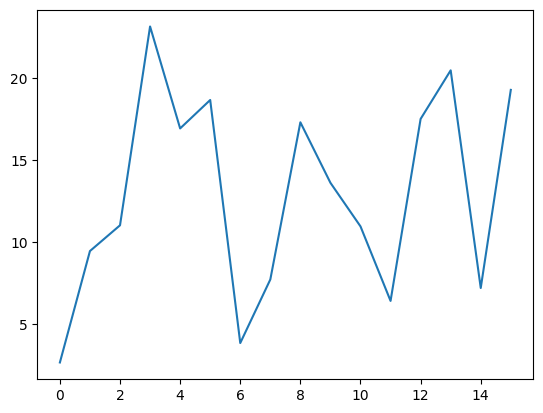

In [54]:
import matplotlib.pyplot as plt
plt.plot(eta_loss_history);# plt.plot(pod_loss_history)

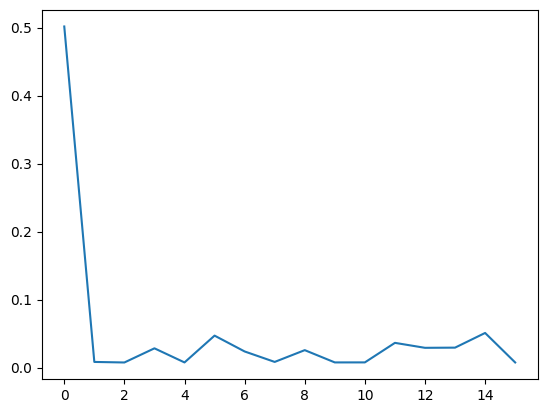

In [55]:
plt.plot(pod_loss_history);

In [ ]:
# 7.  Validation & inference# -----------------------------------------------------------
@torch.no_grad()
def evaluate(model, loader, is_regression):
    model.eval()
    outs, ys = [], []
    for tf_batch in loader:
        outs.append(model(tf_batch).cpu())
        ys.append(tf_batch.y.float().cpu())
    pred = torch.cat(outs).squeeze()
    y    = torch.cat(ys).squeeze()
    if is_regression:
        return torch.mean(torch.abs(pred - y)).item()      # MAE
    else:
        prob = torch.sigmoid(pred)
        acc  = ((prob > 0.5) == y.bool()).float().mean()
        return acc.item()

print("ETA MAE (val):", evaluate(eta_model, val_eta_loader, True))
print("POD ACC (val):", evaluate(pod_model, val_pod_loader, False))

ETA MAE (val): 24.087116241455078
POD ACC (val): 0.949999988079071
